# CMA-ES_MGDA算法

## 概述

在PINNS网络的训练过程中，经常出现高度非线性、非凸的优化问题，本算法将免梯度优化算法—— CMA-ES和多目标梯度优化算法（mgda）相结合，克服优化中的高度非凸、梯度异常难题。

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集
2. 构建神经网络模型、优化器
3. 构建cma-es算法
4. 模型训练

## 引入代码包

In [ ]:
import random
import time
import os
import argparse

import cma
import numpy as np

from mindspore import context, nn, set_seed, save_checkpoint, data_sink
from mindspore.amp import DynamicLossScaler, auto_mixed_precision
from mindflow.utils import load_yaml_config

下述`src`包可以在[research/physics_driven/cma_es_mgda/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/research/cma_es_mgda/src)下载。

In [2]:
from src import flatten_grads
from src import create_dataset, create_model
from src import get_losses, evaluate, visual
from src import resize_array, flatten_grads
from src import get_train_loss_step

set_seed(0)
random.seed(0)

进行参数配置，其中--case有三种选择，"burgers"表示对burgers方程进行训练，"cylinder_flow"表示对navier_stokes2D方程的圆柱绕流数据集进行训练，"periodic_hill"表示对雷诺平均Navier-Stokes方程的山流动数据集进行训练。

In [3]:
parser = argparse.ArgumentParser(description="train cma-es_mgda")
parser.add_argument("--case", type=str, default="burgers", choices=["burgers", "cylinder_flow", "periodic_hill"],
                    help="choose burgers or cylinder_flow")
parser.add_argument("--mode", type=str, default="GRAPH", choices=["GRAPH", "PYNATIVE"],
                    help="Running in GRAPH_MODE OR PYNATIVE_MODE")
parser.add_argument("--device_target", type=str, default="Ascend", choices=["GPU", "Ascend"],
                    help="The target device to run, support 'Ascend', 'GPU'")
parser.add_argument("--device_id", type=int, default=0,
                    help="ID of the target device")
parser.add_argument("--config_file_path", type=str,
                    default="./cma_es_mgda.yaml")
args = parser.parse_args()

context.set_context(mode=context.GRAPH_MODE if args.mode.upper().startswith("GRAPH")
                    else context.PYNATIVE_MODE,
                    save_graphs=args.save_graphs,
                    save_graphs_path=args.save_graphs_path,
                    device_target=args.device_target,
                    device_id=args.device_id)
print(
    f"Running in {args.mode.upper()} mode, using device id: {args.device_id}.")
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
print(use_ascend)
print("pid:", os.getpid())

确定要训练的方程的、进行yaml文件的加载

In [4]:
# get case name
case_name = args.case

# load configurations
config = load_yaml_config(args.config_file_path)

## 创建数据集

下面提供三个案例的数据集讲解，在使用本代码过程中，想要训练哪个数据集就下载哪个数据集并将其放置于src文件夹下。

其中train_dataset用于多目标梯度过程，loss_dataset用于cma-es训练过程中得出解的适应值，inputs、label为测试集。

### burgers数据集

burgers数据集根据求解域、初始条件及边值条件进行随机采样，生成训练数据集与测试数据集。

下载训练与测试数据集： [physics_driven/burgers_pinns/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/burgers_pinns/dataset/)。

### cylinder_flow数据集

cylinder_flow数据集对已有的雷诺数为100的标准圆柱绕流进行初始条件和边界条件数据的采样。对于训练数据集，构建平面矩形的问题域以及时间维度，再对已知的初始条件，边界条件采样；基于已有的流场中的点构造测试集。

下载训练与测试数据集： [physics_driven/flow_past_cylinder/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/flow_past_cylinder/dataset/)。

### Periodic_hill数据集

数据格式为numpy的npy，维度为：[300，700， 10]。其中前两个维度分别为流场的长和宽，最后维度为包含（x, y, u, v, p, uu, uv, vv, rho, nu）共计10个变量。其中，x, y, u, v, p分别为流场的x坐标、y坐标、x方向速度、y方向速度、压力；uu, uv, vv雷诺平均统计量；rho为流体密度，nu为运动粘性系数。

下载训练与测试数据集： [dataset/periodic_hill_2d](https://download.mindspore.cn/mindscience/mindflow/dataset/periodic_hill_2d/)

In [5]:
# create dataset for training, calculating loss and testing
train_dataset, loss_dataset, inputs, label = create_dataset(
    case_name, config)

## 构建模型

本例使用简单的全连接网络，深度为5层，激发函数为`tanh`函数。

In [6]:
# define models
model = create_model(case_name, config)

## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

此处采用进化算法CMA-ES从高斯分布中筛选模型参数，并且对筛选出的参数挑选后代进行多目标梯度下降。

In [10]:
'''Train and evaluate the network'''
# get train epochs
epochs = config["train_epochs"]

# define optimizer
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])

# set ascend
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, config[case_name]["amp_level"])
else:
    loss_scaler = None

# define train_step and loss_step
train_step, loss_step = get_train_loss_step(use_ascend=use_ascend, case_name=case_name,
                                            config=config, model=model, optimizer=optimizer, loss_scaler=loss_scaler)
grad_sink_process = data_sink(train_step, train_dataset, sink_size=1)
loss_sink_process = data_sink(loss_step, loss_dataset, sink_size=1)


# define cma-es
# prepare initial params for cma-es
params, shapes = flatten_grads(optimizer.parameters)

# define cma-es strategy
cma_es = cma.CMAEvolutionStrategy(
    params, config["cmaes"]["std"], {'seed': 0})

# create ckpt dir
if not os.path.exists(os.path.abspath("./ckpt")):
    os.makedirs(os.path.abspath("./ckpt"))


# train loop for cma-es and mgda
for epoch in range(1, epochs + 1):
    # set begin time
    time_beg = time.time()

    # set model to train mode
    model.set_train(True)

    # step1: ask solutions
    solutions = cma_es.ask()

    # step2: random choose some solutions and apply multi-gradient descent algorithm to chosen solutions
    steps_per_epochs = train_dataset.get_dataset_size()
    mgda_number = round(config["mgda"]["ratio"] * cma_es.popsize)
    popn_list = np.arange(0, mgda_number, 1).tolist()
    random_index = random.sample(popn_list, mgda_number)
    for index in random_index:
        tmp_params = solutions[index]
        optimizer.parameters = resize_array(tmp_params, shapes)
        # apply multi-gradient descent algorithm
        for _ in range(steps_per_epochs):
            grad_sink_process()
        solutions[index] = flatten_grads(optimizer.parameters)[0]

    # get corresponding losses
    losses = get_losses(loss_sink_process, solutions, model)

    # step3: tell cma-es the losses of solutions
    cma_es.tell(solutions, losses)

    # current best params
    best_params = cma_es.best.x

    # current best loss
    step_train_loss = cma_es.best.f

    # current epoch loss
    print(
        f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f}ms")

    # set model to eval mode
    model.set_train(False)

    # evaluate best_params if current epoch reaches setting
    if epoch % config["eval_interval_epochs"] == 0:
        model.trainable_parameters = best_params
        evaluate(model, inputs, label, config)

    # save checkpoint
    if epoch % config["save_checkpoint_epochs"] == 0:
        ckpt_name = "ns-{}.ckpt".format(epoch + 1)
        model.trainable_parameters = best_params
        save_checkpoint(model, os.path.join("./ckpt", ckpt_name))
start_time = time.time()
print("End-to-End total time: {} s".format(time.time() - start_time))

burgers: u(x, t)*Derivative(u(x, t), x) + Derivative(u(x, t), t) - 0.00318309897556901*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 3
ic: u(x, t) + sin(3.14159265358979*x)
    Item numbers of current derivative formula nodes: 2
bc: u(x, t)
    Item numbers of current derivative formula nodes: 1
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1341 (seed=1110208, Mon Jul 10 19:06:32 2023)

...
epoch: 100 train loss: 0.08617062121629715 epoch time: 2346.188ms
    predict total time: 238.52849006652832 ms
    l2_error:  0.412801086
...
epoch: 200 train loss: 0.05232620611786842 epoch time: 1371.931ms
    predict total time: 25.633573532104492 ms
    l2_error:  0.294511504
...
epoch: 3800 train loss: 0.0007868735119700432 epoch time: 1506.172ms ms
    predict total time: 2.8052330017089844 ms
    l2_error:  0.046832611
...
epoch: 3900 train loss: 0.0007430368568748236 epoch time: 1457.812ms
    predict total time:  2.6373863220214844 ms
    l2_error:  0.015055131
...
epoch: 4000 train loss: 0.0007280400604940951 epoch time: 1397.658ms
    predict total time: 2.756834030151367 ms
    l2_error:  0.058008888
End-to-End total time: 18195.011221647263 s


## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

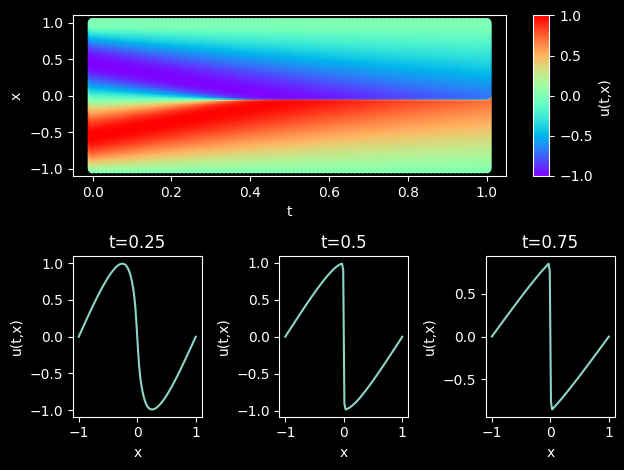

In [11]:
model.trainable_parameters = best_params
visual(case_name, model, config, inputs, label)